## Geologic model of Gottesacker from scratch in GemPy
***
Requires two csv files, one for orientations and one for interfaces. Column headings are case-sensitive and must match the headings used by GemPy:
<br>X Y Z formation                        ---> x, y, and z should be numbers not strings, formation is the formation name string
<br>X Y Z azimuth dip polarity formation   ---> azimuth=strike in degrees, polarity=1
<br>
<br>This version uses data manually pulled from Nico's map - strike & dip points are used for both interface and orientation data. 
Could add points for orientation that aren't at the interface the xed out ones. 

In [1]:
#To-do:
#figure out how to efficiently get points from a geologic map
#georeference Nico's map and get coordinates and elevations for his strike & dip measurements
#import DEM (as tif (or shx?)) and geol map (as tif (or png?)) into python, make sure they are referenced to each other, using geopandas
#if possible import Nico's map with strike  dip measurement locations -might need to georeference first in ArcMap
#enable interactive point picking using bokeh (or matplotlib?)
#set formation first, then pick points interactively and append them to the dataframe for that formation, then run function again for each formation
#add ability to create points by adding or subtracting a formation's thickness from a point on the overlying or underlying formation?
#add x-sections - how to do this? georeference the lines in ArcMap? then what?

## Imports & Setup

In [2]:
# Import packages:

import sys, os
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import theano
import geopandas as geo
import gdal
from copy import copy


sys.path.append("../../..")   #optional: if gempy has been downloaded from GitHub rather than installed normally, look for it in the folders above the current folder
import gempy as gp

# Import local packages:
import elisa

#embed matplotlib figures into notebooks:
%matplotlib inline            

../../..\gempy\plotting\visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../..\gempy\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../..\gempy\posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


575012.5 593962.5 5238037.5 5252987.5


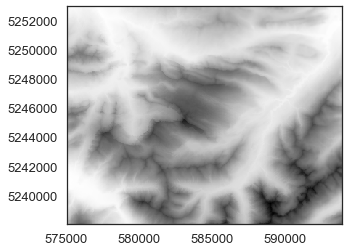

In [3]:
# Import data:

#Option 1: Import DEM from shapefile using geopandas:
dem = geo.read_file('dem50.shx', enabled_drivers=['GeoJSON', 'ESRI Shapefile']) #import shapefile (must be .shx not .shp, and must have all associated files) (also note DEM=DGM, but DEM is NOT the same as DSM)
im = dem['GRID_CODE'].values.reshape(300,380)   #reshape data from x,y,z to a grid
#get extent:
xmin=dem['x'].min()                             
xmax=dem['x'].max()
ymin=dem['y'].min()
ymax=dem['y'].max()
print(xmin,xmax,ymin,ymax)
plt.imshow(im, extent=(xmin,xmax,ymin,ymax)) #plot raster as image

Min z val is equal to nan val - making a copy of the array as floats with np.nan to find true min
[ 574987  594037 5237962 5253012     791    2381] [301 381]


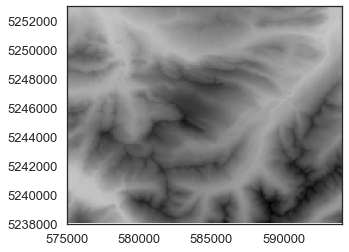

In [4]:
# Option 2:Import DEM from tif file using gdal:
demtif = gdal.Open('DEMraster50.tif')    #DEM must be rectangular tif 


extent, res = elisa.gdal2geodata_extent(demtif)     #get extent and resolution info from dem using gdal
print(extent, res)
xmin=extent[0]                             
xmax=extent[1]
ymin=extent[2]
ymax=extent[3]
zmin=extent[4]
zmax=extent[5]
plt.imshow(demtif.ReadAsArray(), extent=(xmin,xmax,ymin,ymax)) #plot raster as image

In [5]:
geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [89, 56, 50],        #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM)
                       path_i='GK_interfaces.csv',                     #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o='GK_orientations.csv')                   #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

In [6]:
# View geologic info:
gp.get_data(geo_data, itype='formations')   #list formations
#geo_data.interfaces.head()                  #display first few rows of geo_data dataframe
#gp.plot_data(geo_data)                      #plot geo_data
#gp.plot_data_3D(geo_data)                  #plot geo_data in 3D using VTK (optional) (note: when a VTK interactive window is open, nothing else in the notebook can run - pause or close the window before continuing)

,value,formation_number
Amdener,1,1
Drusberg,2,2
Garschella,3,3
Schrattenkalk,4,4
basement,5,5


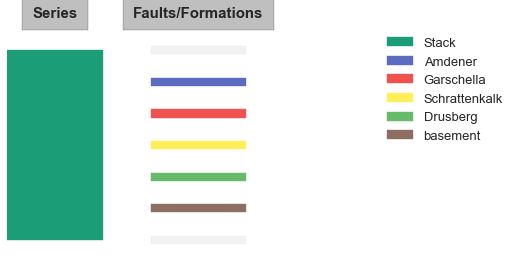

In [7]:
#Set series and formations stratigraphy for viewing:
#to-do: see how hard it would be to make colors customizable
gp.set_series(geo_data, {'Stack': ['Amdener', 'Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer



## Create model

In [8]:
# Interpolate data:
#Caution: takes a while because has to compile. 
#only have to compile once UNLESS change presence of faults or not (number of faults doesn't matter - can change the number of fms & faults afterwards)
#but have to compile after data is imported 
#if changes are made to geo_data after this step, use update_interpolator (see below)
#defaults to float32 - use dtype='float64' to add precision (slower)

interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile', is_lith=True, dtype='float64') #if lith, add is_lith=True, if fault, add is_fault=True



Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0


In [9]:
# Optional: if changes are made to geo_data, can update interpolation without re-compiling:
interp_data.update_interpolator(geo_data)    

In [36]:
# Optional: set faults to be finite:
inf_factor = interp_data.interpolator.tg.inf_factor.get_value()     #fault extent is controlled by an infinity factor (default=10, which is larger than model scale)
inf_factor[0]=0                                                     #set infinity factor to 0 to make faults finite
interp_data.interpolator.tg.inf_factor.set_value(np.zeros(10, dtype="int32"))   #update value 
interp_data.interpolator.tg.inf_factor.get_value()                              #display new values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
# Compute model:
lith = gp.compute_model(interp_data)  #lith is two arrays (each with dim: model extent) with a formation number assigned to each cell 
#if fault is present, outputs are lith, fault = ....
#if lith is overly nested:
lith = lith[0]

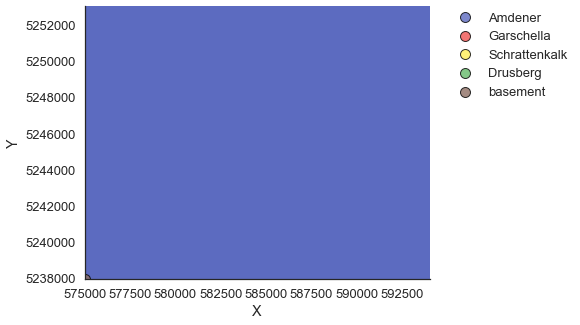

In [11]:
# Display model results:
gp.plotting.plot_section(geo_data, lith[0], 25, plot_data=True, direction='z')   #as cross-section 
#ver, sim = gp.get_surfaces(interp_data, lith[1])                       #create 3D objects for plotting (if fault, add fault[1])
#gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)          #display in 3D with VTK

## Project and crop with topography

In [ ]:
#res for DEMraster100.tif is [56,89], which needs to be flipped to 89, 56, and z res needs to be added

[ 580887  589787 5243012 5248612    1056   32767] [56 89]


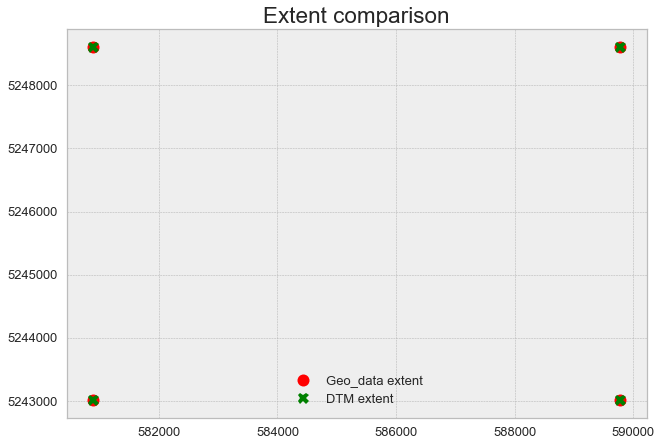

Extent of geo_data and DTM match. You may continue!


C:\Users\Chloe\Documents\GitHub\gempy\notebooks\prototype_notebooks\Chloe_Gottesacker\elisa.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  xyz = pn.read_csv(path_dest, header=None, sep = ' ').as_matrix()


array([[5.8093750e+05, 5.2485625e+06, 1.0000000e+00],
       [5.8103750e+05, 5.2485625e+06, 1.0000000e+00],
       [5.8113750e+05, 5.2485625e+06, 1.0000000e+00],
       ...,
       [5.8953750e+05, 5.2430625e+06, 1.0000000e+00],
       [5.8963750e+05, 5.2430625e+06, 1.0000000e+00],
       [5.8973750e+05, 5.2430625e+06, 1.0000000e+00]])

In [54]:
#to see this working - use DEMraster100.tif for dem, and use same extent for geo_data

import gdal
dem = gdal.Open('DEMraster100.tif')    #DEM must be tif (go back to ArcMap & export a 50m resolution square tif (NOT cropped to watershed boundaries))
extent, res = elisa.gdal2geodata_extent(dem)
print(extent, res)
xmin=extent[0]                             
xmax=extent[1]
ymin=extent[2]
ymax=extent[3]
zmin=extent[4]
zmax=extent[5]
xres = res[1]
yres = res[0]
zres = 50
geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [xres,yres,zres],        #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM)
                       path_i='gottesacker_interfaces.csv',                     #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o='gottesacker_orientations.csv')                   #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

elisa.compare_extent(dem, geo_data)
cropped = dem
cropped.ReadAsArray()[cropped.ReadAsArray() == 32767] = 1000
cropped.ReadAsArray()
g = elisa.tif2xyz('xyz', cropped)
g.reshape(-1, 3)
g2 = g.reshape(-1, 3)
g2[g2[:,2] == 32767, 2] = 1
g2

In [55]:
lith2, fault2 = gp.compute_model_at(g2, interp_data)  #will need to change all following lith to lith2 etc. (for geologic map)
#be careful with overwriting 


In [56]:
print(g.shape)

(56, 89, 3)


In [57]:
56 * 89

4984

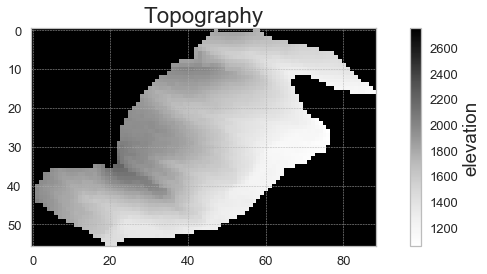

In [58]:
plt.figure(figsize=(12,4))
vdtm = plt.imshow(cropped.ReadAsArray(), vmax=2750)
plt.title("Topography")
cbar = plt.colorbar(vdtm)
cbar.set_label('elevation')

In [59]:
print(geo_data.resolution)

[89 56 50]


In [60]:
#lb = lith2[0].reshape(geo_data.resolution)     #this doesn't work because geo_data.resolution includes vertical resolution term
lb = lith2[0].reshape(geo_data.resolution[0:2])

In [61]:
print(np.shape(lith2[0]))
print(np.shape(lb))

(4984,)
(89, 56)


In [62]:
extent_dtm, res_dtm = elisa.gdal2geodata_extent(cropped)

In [63]:
dtm = cropped.ReadAsArray()
dtm[dtm==32767] = 1056

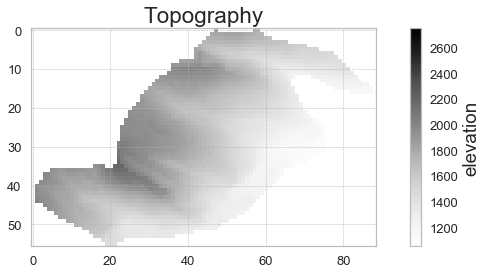

In [65]:
plt.figure(figsize=(12,4))
vdtm = plt.imshow(dtm, vmax=2750)
plt.title("Topography")
cbar = plt.colorbar(vdtm)
cbar.set_label('elevation')

In [66]:
from copy import copy
def height_ind(dtm, zs):
    '''calculate 'indices': array with shape (ext1, ext2) where the values
    are similar if the elevation is similar.
    dtm is the imported dem
    zs is a list of possible z values (can generate with linspace from zmin, zmax, and zres)'''  
    #zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    #dz = geo_data.extent[5] - geo_data.extent[4])/geo_data.resolution[2]
    # dz is number of points in z direction
    dz = (zs[-1] - zs[0]) / len(zs)
    print(dz)
    #2. substract minimum value (here -1000) from each value of dtm and divide it by dz
    dtm_v = (dtm - zs[0]) / dz
    return dtm_v.astype(int)


def calculate_geomap(lb, dtm, geo_data, plot=True):
    zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    indices = height_ind(dtm,zs).T   
    geomap = np.zeros((lb.shape[0],lb.shape[1]))
    for x in range(lb.shape[0]):
        for y in range(lb.shape[1]):
            geomap[x,y] = lb[x,y,indices[x,y]]   
    if plot:
        plt.imshow(geomap.T, origin="upper", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
        plt.title("Geological map")    
    return geomap.T  

def extend_lithblock(lb, factor):
    fertig2 = []
    for i in range(0,lb.shape[2]):
        lb_sub=lb[:,:,i]
        fertig = []
        for j in range(0, lb.shape[0]):
            y = np.repeat(lb_sub[j,:], factor)
            fertig = np.append(fertig, [y]*factor)
        fertig = fertig.reshape(lb.shape[0]*factor, lb.shape[1]*factor)
        fertig2.append(fertig)
        fertig2.append(fertig)
        fertig2.append(fertig)
        fertig2.append(fertig)
    return np.dstack(fertig2)

def mask_lith_block_above_topo(lb, geo_data, dtm):
    '''hier wird allen Werten die oberhalb der topographie 
    liegen ein minus eins zugewiesen und das dann maskiert'''
    zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    indices = height_ind(dtm,zs).T

    geoblock = copy(lb)
    for x in range(lb.shape[0]):
        for y in range(lb.shape[1]):
            z = indices[x,y]
            geoblock[x,y,z:] = -1
    
    return np.ma.masked_where(geoblock < 0, geoblock)

In [83]:
newdem = height_ind(dtm,np.linspace(zmin, zmax, zres))
print(np.shape(newdem))
print(np.min(newdem))


(56, 89)
0


In [74]:
#np.unique(height_ind(dtm,np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])).T)
np.unique(height_ind(dtm,np.linspace(zmin, zmax, zres)).T)

array([0, 1])

In [50]:
geomap = calculate_geomap(lb,dtm, geo_data, plot = True)


IndexError: tuple index out of range

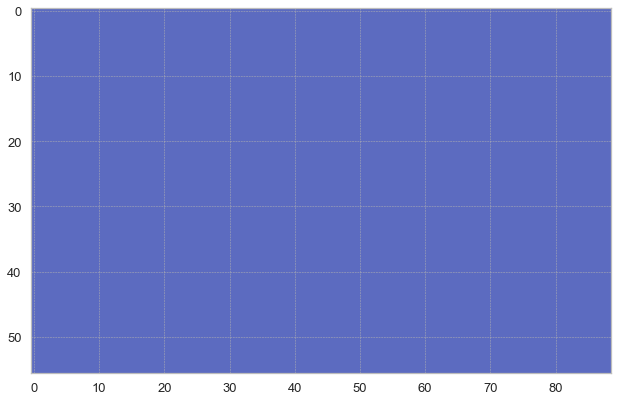

In [52]:
plt.imshow(lith2[0].reshape(56, 89),  origin="upper", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)

In [96]:
dtm

array([[1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       ...,
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056]], dtype=int16)

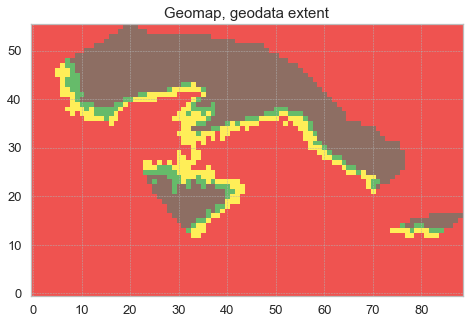

In [71]:
plt.figure(1, figsize = (10,5))
plt.imshow(geomap, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
plt.title("Geomap, geodata extent", fontsize = 15)   

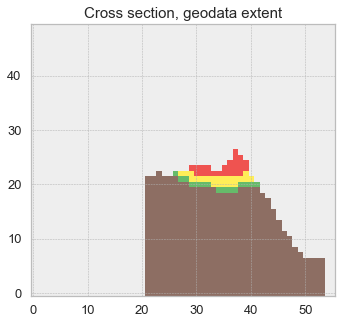

In [94]:
geoblock = mask_lith_block_above_topo(lb, geo_data, dtm)
plt.figure(1, figsize = (10,5))
fig = plt.imshow(geoblock[25,:,:].T, origin="lower", cmap=gp.plotting.colors.cmap,norm=gp.plotting.colors.norm)
plt.title("Cross section, geodata extent", fontsize = 15)  

In [73]:

lb.shape

(89, 56, 50)